In [1]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [2]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体
matplotlib.rcParams['font.family']='sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False #解决负号'-'显示为方块的问题

def get_url(url, params=None, proxies=None):  # 抓取网页
    rsp = requests.get(url, params=params, proxies=proxies)
    rsp.raise_for_status()
    return rsp.text

def get_fund_data(code,per=10,sdate='',edate='',proxies=None):  # 从网页抓取数据
    url = 'http://fund.eastmoney.com/f10/F10DataApi.aspx'
    params = {'type': 'lsjz', 'code': code, 'page':1,'per': per, 'sdate': sdate, 'edate': edate}
    html = get_url(url, params, proxies)
    soup = BeautifulSoup(html, 'html.parser')
   
    pattern=re.compile(r'pages:(.*),')  # 获取总页数
    result=re.search(pattern,html).group(1)
    pages=int(result)
    heads = [] # 获取表头
    for head in soup.findAll("th"):
        heads.append(head.contents[0])
    records = []
    page=1  # 从第1页开始抓取所有页面数据
    while page<=pages:
        params = {'type': 'lsjz', 'code': code, 'page':page,'per': per, 'sdate': sdate, 'edate': edate}
        html = get_url(url, params, proxies)
        soup = BeautifulSoup(html, 'html.parser')
        for row in soup.findAll("tbody")[0].findAll("tr"):
            row_records = []
            for record in row.findAll('td'):
                val = record.contents
                if val == []:
                    row_records.append(np.nan)
                else:
                    row_records.append(val[0])
            records.append(row_records)
        page=page+1
    np_records = np.array(records)
    data= pd.DataFrame()
    for col,col_name in enumerate(heads):
        data[col_name] = np_records[:,col]

    df = pd.DataFrame(data) #将dataframe数据转化为列表，将字符串转化为数字
    a=df['单位净值'].tolist()
    list.reverse(a)
    global aa
    aa=[]
    for i in a:
        aa.append(float(i))
    return data

In [3]:
etf='515800'                   #基金代码
start='2020-01-01'            #开始日期
end='2023-04-15'              #结束日期

data=get_fund_data(etf,per=49,sdate=start,edate=end)
data['净值日期']=pd.to_datetime(data['净值日期'],format='%Y/%m/%d') # 修改数据类型
data['单位净值']= data['单位净值'].astype(float)
data['累计净值']=data['累计净值'].astype(float)
data['日增长率']=data['日增长率'].str.strip('%').astype(float)
data=data.sort_values(by='净值日期',axis=0,ascending=True).reset_index(drop=True) # 按照日期升序排序并重建索引
net_value_date = data['净值日期']

adjnav=data[['净值日期','累计净值']]
adjnav.columns=['date','adjnav']
adjnav_1=adjnav.set_index('date')

In [4]:
grid=adjnav_1.rolling(126).std()/25  #网格大小=价格半年波动率/25
grid.index=grid.index.astype('datetime64[ns]')
adjnav_1.index=adjnav_1.index.astype('datetime64[ns]')
grid_1=grid.resample('M').ffill().resample('D').ffill()
grid_1.columns=['grid']
adjnav_2=adjnav_1.merge(grid_1,how='left',on='date').dropna()

In [5]:
adjnav_shift=adjnav_1.shift(1)
adjnav_shift.columns=['adjnav_shift']
adjnav_3=adjnav_2.merge(adjnav_shift,how='left',on='date')
adjnav_3['adjnav_sub']=adjnav_3['adjnav']-adjnav_3['adjnav_shift']  #计算价格差和网格进行对比
adjnav_3['cross']=adjnav_3['adjnav_sub']-adjnav_3['grid'] #判断是否穿网格
adjnav_3['cross_num']=adjnav_3['cross']//adjnav_3['grid']  #判断穿网格数量，-1和0表示未穿网格
adjnav_3.loc[adjnav_3['cross_num']==-1,'cross_num']=0 #把-1变为0
adjnav_4=adjnav_3[['adjnav','grid','adjnav_sub','cross_num']].reset_index()

In [6]:
number=50 #穿网格线买卖份数
initial=2000 #初始买入基金金额
initial_free=8000 #可用金额

#计算买入卖出的金额
for i in range(0,len(adjnav_4)):
    if adjnav_4.loc[i,'adjnav_sub']>0:
        adjnav_4.loc[i,'price_change']=adjnav_4.loc[i,'cross_num']*adjnav_4.loc[i,'adjnav']*number 
    elif adjnav_4.loc[i,'adjnav_sub']<0:
        adjnav_4.loc[i,'price_change']=adjnav_4.loc[i,'cross_num']*adjnav_4.loc[i,'adjnav']*number

In [7]:
adjnav_5=adjnav_4[['date','adjnav','cross_num','price_change']] #price_change为正表示向上穿，卖出
adjnav_5=adjnav_5.fillna(0)
adjnav_5.loc[0,'price']=initial
adjnav_5.loc[0,'num']=initial/adjnav_5.loc[0,'adjnav']  #计算初始份额

for i in range(0,len(adjnav_5)-1):
    adjnav_5.loc[i+1,'num']= adjnav_5.loc[i,'num']-adjnav_5.loc[i+1,'cross_num']*number  #计算实时持有份额
    adjnav_5.loc[i+1,'price']= adjnav_5.loc[i,'price']-adjnav_5.loc[i+1,'price_change'] #price表示投资金额
    
    #若投资金额超过账户总金额,则卖出现有份额的1/3
    if adjnav_5.loc[i+1,'price']>=initial+initial_free:  
        adjnav_5.loc[i+1,'num']=adjnav_5.loc[i,'num']*2/3  #卖出现有份额的1/3
        adjnav_5.loc[i+1,'return']=adjnav_5.loc[i+1,'num']*adjnav_5.loc[i+1,'adjnav']  #持有基金价值=份额*净值
        adjnav_5.loc[i+1,'price']=adjnav_5.loc[i,'price']-adjnav_5.loc[i,'num']*1/3*adjnav_5.loc[i+1,'adjnav']   #投资金额

    adjnav_5.loc[i+1,'return']=adjnav_5.loc[i+1,'num']*adjnav_5.loc[i+1,'adjnav'] #return表示持有基金价值
    adjnav_5.loc[i+1,'profit']=adjnav_5.loc[i+1,'return']/adjnav_5.loc[i+1,'price']-1  #profit表示收益率   
    
    #止损：若收益率<=-0.3,则卖出现有份额的1/2
    if adjnav_5.loc[i+1,'profit']<=-0.3:  
        adjnav_5.loc[i+1,'num']=adjnav_5.loc[i,'num']*1/2  #卖出现有份额的1/2
        adjnav_5.loc[i+1,'return']=adjnav_5.loc[i+1,'num']*adjnav_5.loc[i+1,'adjnav']  #持有基金价值=份额*净值
        adjnav_5.loc[i+1,'price']=adjnav_5.loc[i,'price']-adjnav_5.loc[i,'num']*1/2*adjnav_5.loc[i+1,'adjnav']   #投资金额
        
     #止盈：若收益率>=0.7,则卖出现有份额的1/2
    if adjnav_5.loc[i+1,'profit']>0.5:  
        adjnav_5.loc[i+1,'num']=adjnav_5.loc[i,'num']*1/2  #卖出现有份额的1/2
        adjnav_5.loc[i+1,'return']=adjnav_5.loc[i+1,'num']*adjnav_5.loc[i+1,'adjnav']  #持有基金价值=份额*净值
        adjnav_5.loc[i+1,'price']=adjnav_5.loc[i,'price']-adjnav_5.loc[i,'num']*1/2*adjnav_5.loc[i+1,'adjnav']   #投资金额

<Axes: xlabel='date'>

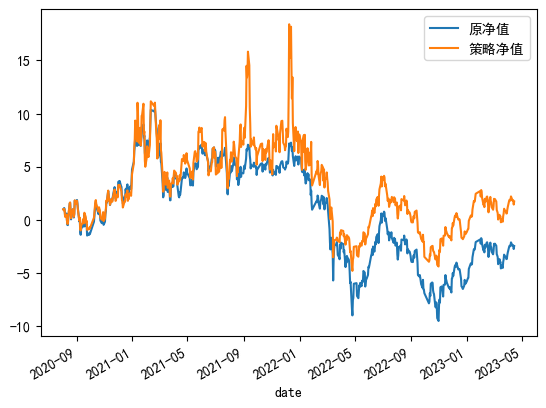

In [8]:
#基金累计收益率
df_date=adjnav_5[['date']]
adjnav_profit=pd.merge(adjnav_1,df_date,how='inner',on='date')  
adjnav_profit['adjnav_profit']=adjnav_profit['adjnav']/adjnav_profit['adjnav'].tolist()[0]-1  #原基金净值

adjnav_6=adjnav_5[['date','profit']] #策略净值
compare=pd.merge(adjnav_profit[['date','adjnav_profit']],adjnav_6,how='inner',on='date').dropna().set_index('date')
compare['profit']=compare['profit']/compare['profit'].tolist()[0]
compare['adjnav_profit']=compare['adjnav_profit']/compare['adjnav_profit'].tolist()[0]
compare.columns=['原净值','策略净值']
compare.plot()